In [1]:
# %pip install kagglehub

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

# print("Path to dataset files:", path)

In [3]:
#%pip install matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = sorted([
            f for f in os.listdir(image_dir) if f.endswith(".jpg")
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
class NumpyArrayDataset(Dataset):
    def __init__(self, np_array, labels=None, transform=None):
        """
        Args:
            images (numpy.ndarray): Array of images (e.g., shape (N, H, W) or (N, H, W, C)).
            labels (numpy.ndarray or None): Optional array of labels (e.g., shape (N,)).
            transform (callable, optional): Transformations to apply to the images.
        """
        self.data = np_array
        self.labels = torch.from_numpy(labels).long() if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        datapoint = self.data[idx]
        if self.transform:
            datapoint = self.transform(datapoint)
        if self.labels is not None:
            label = self.labels[idx]
            return datapoint, label
        return datapoint

class MNISTImagesOnly(Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(
            root="./data",
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: 2*x - 1)
            ])
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # ignore the label
        return image  # only return image

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# img_size = 48
# img_size = 16

transform = transforms.Compose([
    # transforms.Resize(img_size),
    # transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0))
])

batch_size = 64
# image_dir = "/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"
# dataset = CelebADataset(image_dir=image_dir, transform=transform)
# len(dataset)

images = np.load('sprites.npy')
img_height, img_width, channels = images[0].shape
dataset = NumpyArrayDataset(images, transform=transform)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)
# train_loader = DataLoader(MNISTImagesOnly(train=True), batch_size=256, shuffle=True, drop_last=True)

Img batch dims: torch.Size([256, 3, 16, 16])


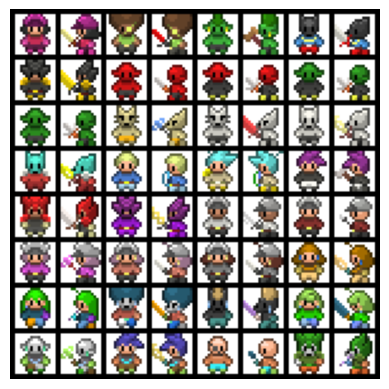

In [4]:
for images in train_loader:
    print("Img batch dims:", images.shape)
    channels = images.shape[1]
    img_size = images.shape[2]
    break
    
imgs = [train_loader.dataset[i] for i in range(64)]
img_batch = torch.stack(imgs, dim=0)
grid = torchvision.utils.make_grid(img_batch, padding=2, normalize=True)
    
plt.axis(False)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.savefig("dataset.png")
plt.show()

## Architecture

In [5]:
import math

def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    emb = math.log(10000) / (half - 1)
    emb = torch.exp(torch.arange(half, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]  # (B, half)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # (B, dim)

In [6]:
# ----------- Residual Block with Time Embedding --------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

        self.block1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if use_attention:
            self.attn = SelfAttentionBlock(out_channels)

    def forward(self, x, t_emb):
        h = self.block1(x)
        t = self.time_mlp(t_emb).view(x.shape[0], -1, 1, 1)
        h = h + t
        h = self.block2(h)

        if self.use_attention:
            h = self.attn(h)

        return h + self.res_conv(x)

# ----------- Self-Attention for 16x16 resolution --------------------------
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.proj = nn.Conv1d(channels, channels, 1)

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape
        x = self.norm(x)
        x = x.view(B, C, H * W)  # (B, C, N)
        qkv = self.qkv(x)  # (B, 3C, N)
        q, k, v = qkv.chunk(3, dim=1)
        attn = torch.softmax(q.transpose(1, 2) @ k / math.sqrt(C), dim=-1)  # (B, N, N)
        out = v @ attn.transpose(1, 2)  # (B, C, N)
        out = self.proj(out)
        return (x + out).view(B, C, H, W)

# ----------- Down/Up sampling ---------------------------------------------
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.op = nn.Conv2d(channels, channels, 4, stride=2, padding=1)
    def forward(self, x):
        return self.op(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.op = nn.ConvTranspose2d(channels, channels, 4, stride=2, padding=1)
    def forward(self, x):
        return self.op(x)

# ----------- Final U-Net --------------------------------------------------
class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Downsampling
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.res1 = ResidualBlock(base_channels, base_channels, time_emb_dim)
        self.down1 = Downsample(base_channels)

        self.res2 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.down2 = Downsample(base_channels * 2)

        self.res3 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim, use_attention=True)

        # Middle
        self.mid1 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)
        self.mid2 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        # Upsampling
        self.up1 = Upsample(base_channels * 4)
        self.res4 = ResidualBlock(base_channels * 6, base_channels * 2, time_emb_dim)   # changed this

        self.up2 = Upsample(base_channels * 2)
        self.res5 = ResidualBlock(base_channels * 3, base_channels, time_emb_dim, use_attention=True)

        self.conv_out = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)
    
        x1 = self.conv_in(x)
        x2 = self.res1(x1, t_emb)
        x3 = self.down1(x2)
    
        x4 = self.res2(x3, t_emb)
        x5 = self.down2(x4)
    
        x6 = self.res3(x5, t_emb)
    
        x_mid = self.mid1(x6, t_emb)
        x_mid = self.mid2(x_mid, t_emb)
    
        x = self.up1(x_mid)
        x = torch.cat((x, x4), dim=1)  # skip connection
        x = self.res4(x, t_emb)
    
        x = self.up2(x)
        x = torch.cat((x, x2), dim=1)  # skip connection
        x = self.res5(x, t_emb)
    
        return self.conv_out(x)

In [7]:
model = SmallUNet(base_channels=32, time_emb_dim=128)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1687395


In [8]:
x = torch.randn(batch_size, 3, img_size, img_size)
t = torch.randint(0, 1000, (batch_size,))  # discrete timestep IDs
out = model(x, t)  # shape: [B, channels, img_height, img_width]

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

In [10]:
def q_sample(x, t, epsilon, alphas_bar):
    """
    x: clean image (B, C, H, W)
    t: timestep tensor (B,)
    epsilon: noise (B, C, H, W)
    alphas_bar: precomputed ᾱ_t schedule (T,)
    """
    sqrt_alpha_bar = torch.sqrt(alphas_bar[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_bar[t]).view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * epsilon

In [11]:
# Training
model = SmallUNet(in_channels=channels)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: min((step + 1) / 500, 1.0)
)

# as in paper
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0).to(device)

In [12]:
import torch
from tqdm import tqdm
import os

scaler = torch.amp.GradScaler('cuda')  # initialize gradient scaler

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(1000):
    loop = tqdm(train_loader, desc=f"Epoch {i+1}", leave=False)
    for x0 in loop:
        optimizer.zero_grad()
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.shape[0],), device=device).long()
        epsilon = torch.randn_like(x0)

        with torch.amp.autocast('cuda'):  # enable mixed precision
            x_t = q_sample(x0, t, epsilon, alphas_bar)
            pred_noise = model(x_t, t)
            loss = torch.nn.functional.mse_loss(pred_noise, epsilon)

        scaler.scale(loss).backward()          # scale the loss
        scaler.step(optimizer)                  # scaled optimizer step
        scaler.update()                        # update scale for next iteration

        scheduler.step()
        loop.set_postfix(loss=loss.item())

    # Save checkpoint at end of epoch
    # checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{i+1}.pt")
    # torch.save({
    #     "epoch": i + 1,
    #     "model_state_dict": model.state_dict(),
    #     "optimizer_state_dict": optimizer.state_dict(),
    #     "loss": loss.item(),
    # }, checkpoint_path)

    print(f"[Epoch {i+1}] Loss: {loss.item():.4f}")

[Epoch 1] Loss: 0.1379


[Epoch 2] Loss: 0.0788


[Epoch 3] Loss: 0.0666


[Epoch 4] Loss: 0.0712


[Epoch 5] Loss: 0.0586


[Epoch 6] Loss: 0.0534


[Epoch 7] Loss: 0.0457


[Epoch 8] Loss: 0.0495


[Epoch 9] Loss: 0.0426


[Epoch 10] Loss: 0.0420


[Epoch 11] Loss: 0.0358


[Epoch 12] Loss: 0.0286


[Epoch 13] Loss: 0.0357


[Epoch 14] Loss: 0.0231


[Epoch 15] Loss: 0.0277


[Epoch 16] Loss: 0.0241


[Epoch 17] Loss: 0.0242


[Epoch 18] Loss: 0.0225


[Epoch 19] Loss: 0.0258


[Epoch 20] Loss: 0.0197


[Epoch 21] Loss: 0.0270


[Epoch 22] Loss: 0.0164


[Epoch 23] Loss: 0.0177


[Epoch 24] Loss: 0.0257


[Epoch 25] Loss: 0.0182


[Epoch 26] Loss: 0.0169


[Epoch 27] Loss: 0.0217


[Epoch 28] Loss: 0.0173


[Epoch 29] Loss: 0.0182


[Epoch 30] Loss: 0.0164


[Epoch 31] Loss: 0.0171


[Epoch 32] Loss: 0.0164


[Epoch 33] Loss: 0.0130


[Epoch 34] Loss: 0.0127


[Epoch 35] Loss: 0.0188


[Epoch 36] Loss: 0.0154


[Epoch 37] Loss: 0.0188


[Epoch 38] Loss: 0.0184


[Epoch 39] Loss: 0.0117


[Epoch 40] Loss: 0.0102


[Epoch 41] Loss: 0.0131


[Epoch 42] Loss: 0.0139


[Epoch 43] Loss: 0.0094


[Epoch 44] Loss: 0.0119


[Epoch 45] Loss: 0.0118


[Epoch 46] Loss: 0.0125


[Epoch 47] Loss: 0.0135


[Epoch 48] Loss: 0.0155


[Epoch 49] Loss: 0.0119


[Epoch 50] Loss: 0.0143


[Epoch 51] Loss: 0.0131


[Epoch 52] Loss: 0.0107


[Epoch 53] Loss: 0.0120


[Epoch 54] Loss: 0.0107


[Epoch 55] Loss: 0.0105


[Epoch 56] Loss: 0.0118


[Epoch 57] Loss: 0.0082


[Epoch 58] Loss: 0.0095


[Epoch 59] Loss: 0.0137


KeyboardInterrupt: 

In [13]:
# Save model
torch.save(model.state_dict(), "diffusion_unet_spries.pt")

In [14]:
# Sampling
@torch.no_grad()
def sample(model, T, alphas, alphas_bar, img_size, channels=3, device="cpu", seed=123, save_steps=True):
    """
    Diffusion sampling (DDPM) with proper scaling to produce visible images.
    Returns final image and optional intermediate steps as PIL images.
    """
    model.eval()
    steps = [] if save_steps else None
    to_pil = Transforms.ToPILImage()

    torch.manual_seed(seed)
    x_t = torch.randn((1, channels, img_size, img_size), device=device)  # x_T ~ N(0, I)

    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device)

        alpha_t = alphas[t]
        alpha_bar_t = alphas_bar[t]

        pred_noise = model(x_t, t_tensor)  # predict ε_θ(x_t, t)

        # DDPM update rule
        coeff = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        x_0_pred = (x_t - coeff * pred_noise) / torch.sqrt(alpha_t)

        if t > 0:
            z = torch.randn_like(x_t)
            # beta_t = 1 - alpha_t / alphas[t - 1]
            beta_t = betas[t]
            sigma_t = torch.sqrt(beta_t)
            x_t = torch.sqrt(alpha_t) * x_0_pred + sigma_t * z
        else:
            x_t = x_0_pred  # final image

        # save steps as scaled PIL images
        if save_steps and t % max(1, (T // 10)) == 0:
            step = (x_t - x_t.min()) / (x_t.max() - x_t.min())
            step = step.clamp(0, 1)
            steps.append(to_pil(step.squeeze(0).cpu()))

    # final image scaling
    x_t = (x_t - x_t.min()) / (x_t.max() - x_t.min())
    x_t = x_t.clamp(0, 1)
    final_img = to_pil(x_t.squeeze(0).cpu())

    if save_steps:
        return final_img, steps
    else:
        return final_img

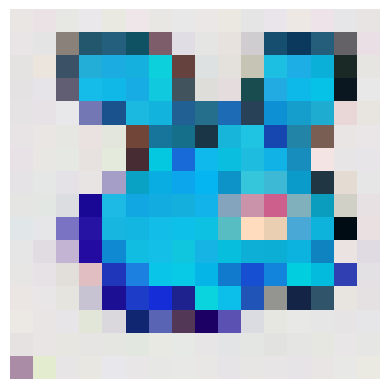

In [15]:
import torchvision.transforms as Transforms
import time

T = 1000
img = sample(model, T, alphas, alphas_bar, img_size=img_size, channels=channels, device=device, seed=int(time.time()), save_steps=False)
# img = img.resize((128, 128), resample=3)  # upscale for better viewing
plt.imshow(img)
plt.axis("off")
plt.savefig("result.png")
plt.show()

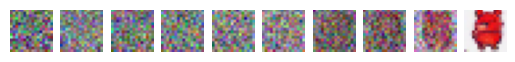

In [16]:
_, steps = sample(model, T, alphas, alphas_bar, img_size=img_size, channels=channels, device=device, seed=int(time.time()), save_steps=True)

for i, img in enumerate(steps):
    plt.subplot(1, len(steps), i+1)
    plt.imshow(img)
    plt.axis("off")
plt.savefig("generating.png")
plt.show()

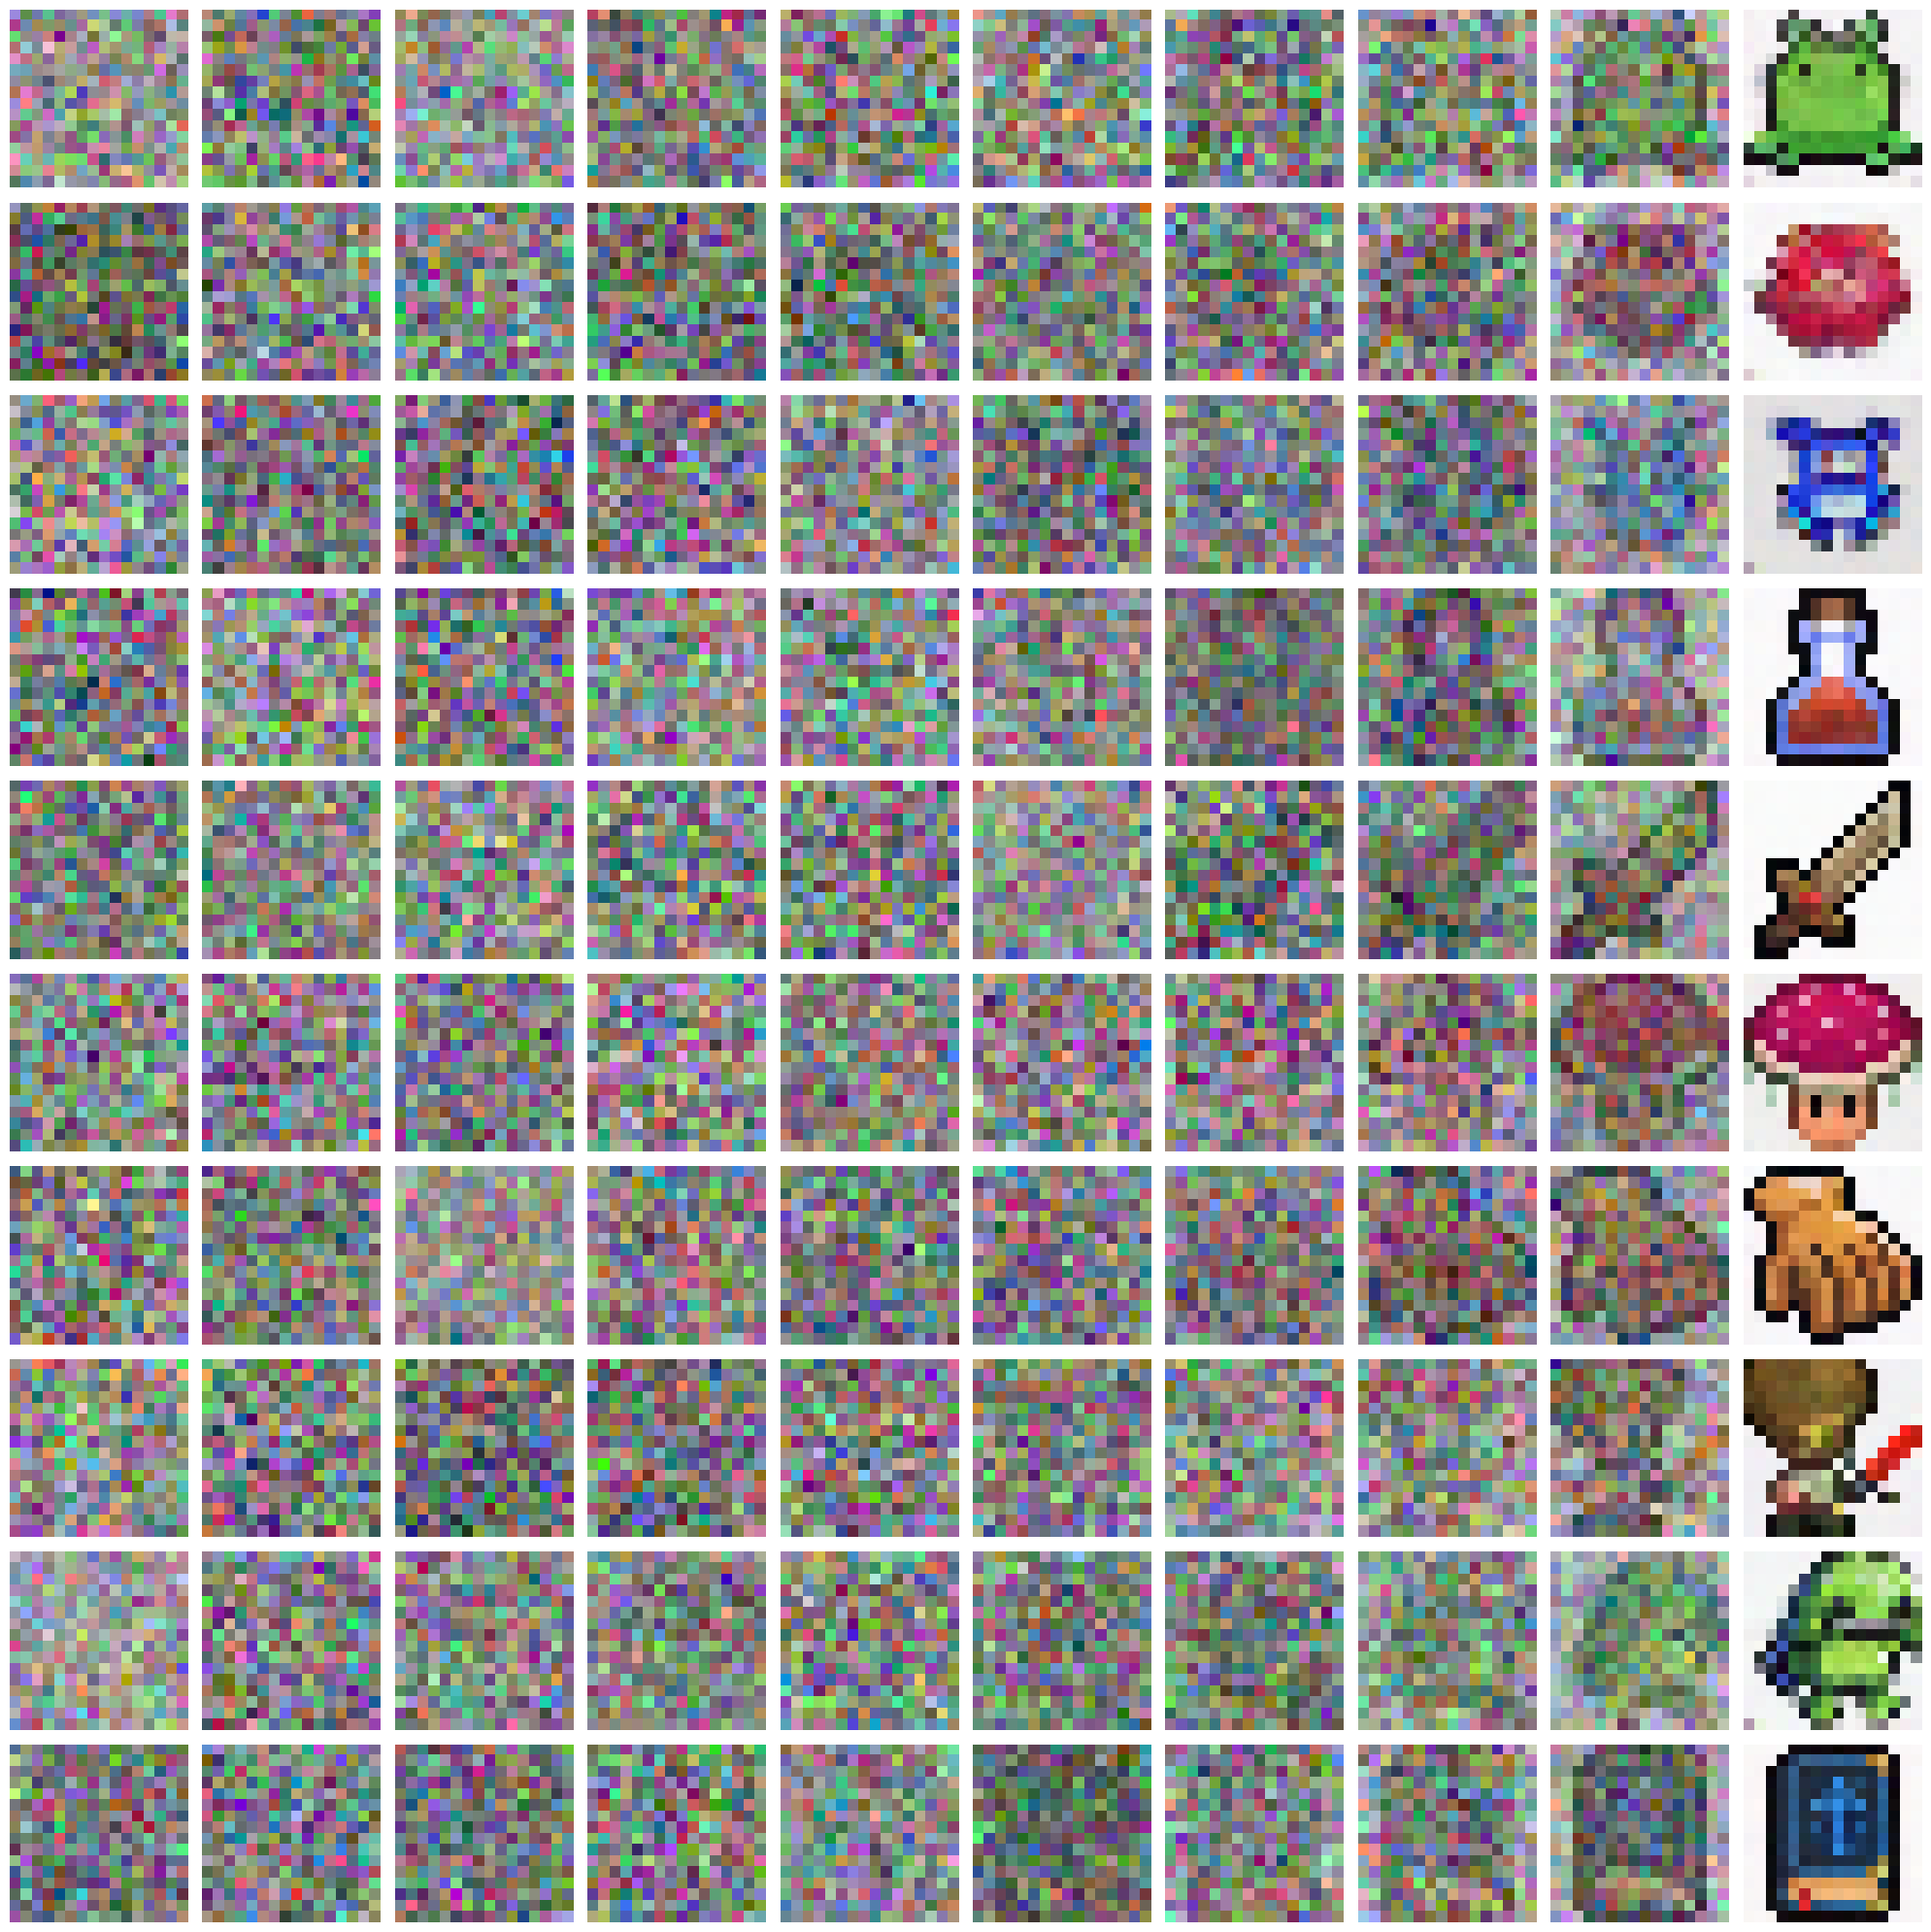

In [17]:
num_samples = 10  # number of separate generation runs
all_steps = []

# Run the diffusion multiple times and store steps
for s in range(num_samples):
    _, steps = sample(
        model, T, alphas, alphas_bar,
        img_size=img_size, channels=channels,
        device=device, seed=int(time.time()) + s,
        save_steps=True
    )
    all_steps.append(steps)

# Determine grid size
num_steps = len(all_steps[0])  # steps per generation
fig, axes = plt.subplots(nrows=num_samples, ncols=num_steps, figsize=(num_steps*2, num_samples*2))

# If axes is 1D when num_samples=1, make it 2D
if num_samples == 1:
    axes = axes[None, :]

for row_idx, steps in enumerate(all_steps):
    for col_idx, img in enumerate(steps):
        ax = axes[row_idx, col_idx]
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.savefig("generating_multiple.png")
plt.show()